From https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e

In [3]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, regularizers
from tensorflow.keras import models
#import tensorflow_datasets as tfds

In [4]:
import ffmpeg
from pydub import AudioSegment

In [5]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'dublin_dl_birds_split/'
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category]
categories

['Coal Tit',
 'Common Blackbird',
 'Common Chaffinch',
 'Common Starling',
 'Eurasian Blue Tit',
 'Eurasian Magpie',
 'European Goldfinch',
 'European Greenfinch',
 'European Herring Gull',
 'European Robin',
 'Great Tit',
 'Grey Heron',
 'House Sparrow',
 'Mediterranean Gull',
 'Northern Gannet']

In [6]:
AudioSegment.ffprobe  = "/usr/local/bin/ffmpeg"

In [7]:
import soundfile as sf
def get_waveform_and_label(file_path):
    label        = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform     = decode_audio(audio_binary)
    return waveform, label

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [9]:
def decode_audio(audio_binary):
    audio, samp_rate = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
    #return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis
    return audio[:,0]

In [11]:
import random
filenames = random.sample(tf.io.gfile.glob(str(data_dir) + '*/*'), 1000)

In [12]:
#filenames = tf.io.gfile.glob(str(data_dir) + '*/*')[:1000]
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)

In [13]:
filenames

<tf.Tensor: shape=(1000,), dtype=string, numpy=
array([b'dublin_dl_birds_split\\Coal Tit\\xc650781_start_0_45.wav',
       b'dublin_dl_birds_split\\Northern Gannet\\xc189864_start_0_45.wav',
       b'dublin_dl_birds_split\\European Herring Gull\\xc194045_start_2_0.wav',
       b'dublin_dl_birds_split\\European Greenfinch\\xc601911_start_1_30.wav',
       b'dublin_dl_birds_split\\Common Starling\\xc361388_start_1_15.wav',
       b'dublin_dl_birds_split\\Mediterranean Gull\\xc544010_start_0_15.wav',
       b'dublin_dl_birds_split\\Eurasian Magpie\\xc627439_start_1_30.wav',
       b'dublin_dl_birds_split\\Northern Gannet\\xc120833_start_4_0.wav',
       b'dublin_dl_birds_split\\Common Starling\\xc463564_start_2_15.wav',
       b'dublin_dl_birds_split\\Common Blackbird\\xc634922_start_2_45.wav',
       b'dublin_dl_birds_split\\Common Starling\\xc647766_start_1_15.wav',
       b'dublin_dl_birds_split\\Common Blackbird\\xc598937_start_0_0.wav',
       b'dublin_dl_birds_split\\European Herrin

In [14]:
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(pathlib.Path(data_dir)/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1000
Number of examples per label: 431
Example file tensor: tf.Tensor(b'dublin_dl_birds_split\\Coal Tit\\xc650781_start_0_45.wav', shape=(), dtype=string)


In [15]:
TRAIN_SIZE = 0.8

cutoff = int(len(filenames) * TRAIN_SIZE)
train_files = filenames[:cutoff]
test_files  = filenames[cutoff:]

print('Training set size:',   len(train_files))
print('Validation set size:', len(test_files))

Training set size: 800
Validation set size: 200


In [16]:
AUTOTUNE    = tf.data.experimental.AUTOTUNE
files_ds    = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [17]:
from scipy.io import wavfile

In [18]:
samp_rate, _ = wavfile.read(train_files[0].numpy())

In [19]:
def get_spectrogram(waveform):
    #cutoff spectrogram size to either splice or pad
    pad_cut  = tf.constant([5000, 2*129])
    waveform = tf.cast(waveform, tf.float32)
    
    # produces an array of complex numbers representing magnitude and phase
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128) #frame_step=1 would give spectrogram same length as audio plot

    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    
    #if length < pad_cut
    ## Concatenate with padding (close to 0) so that all specrograms will be of the same length 
    #else if length > pad_cut
    ## cut off anything in the spectrogram after pad_cut
    zero_padding = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
                          lambda: tf.ones([1,1]), #some basic tensor, won't be used
                          lambda: tf.ones(pad_cut - tf.shape(spectrogram), dtype=tf.float32)*1e-8)
    spectrogram = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
                          lambda: tf.slice(spectrogram, [0,0], [pad_cut[0], 129]), 
                          lambda: tf.concat([spectrogram, zero_padding], 0))

    return spectrogram

In [20]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == categories)
    return spectrogram, label_id

In [21]:
def preprocess_dataset(files):
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [22]:
train_files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds    = train_files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [23]:
train_ds = preprocess_dataset(train_files)
test_ds  = preprocess_dataset(test_files)

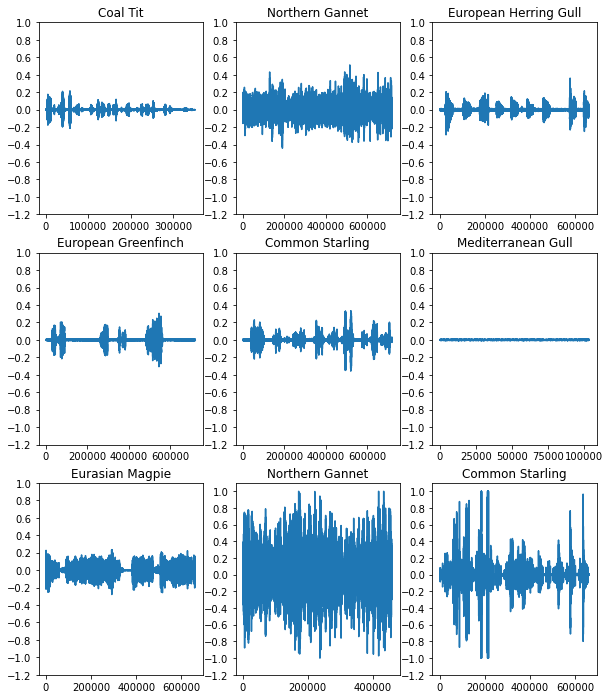

In [24]:
rows = 3
cols = 3
n    = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio)
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [25]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Audio playback')
display.display(display.Audio(waveform, rate=samp_rate))

Label: Coal Tit
Waveform shape: (352798,)
Spectrogram shape: (5000, 129)


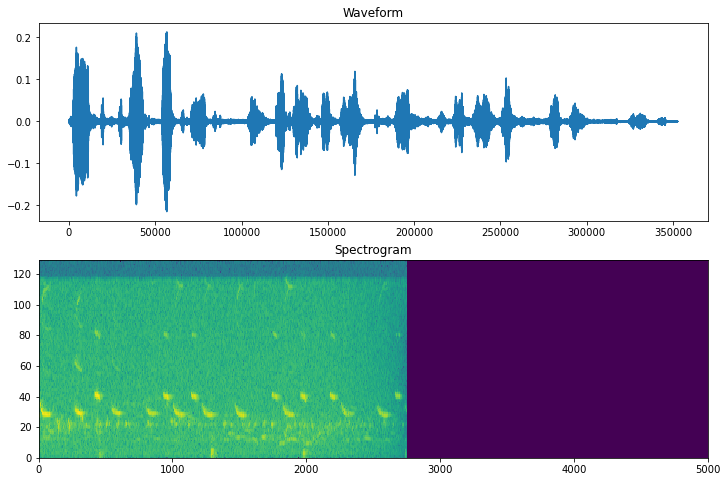

In [26]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    ax.pcolormesh(log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
#axes[0].set_xlim([0, 661500])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [27]:
#train_labs = [int(y) for _, y in train_ds]
#test_labs  = [int(y) for _, y in test_ds]

In [28]:
def get_just_label(file_path):
    label    = get_label(file_path)
    label_id = tf.argmax(label == categories)
    return label_id

In [29]:
train_labs_tmp = [int(get_just_label(f)) for f in train_files]
test_labs_tmp  = [int(get_just_label(f)) for f in test_files]

In [30]:
train_labs_sort = train_labs_tmp
test_labs_sort  = test_labs_tmp
train_labs_sort.sort()
test_labs_sort.sort()

Text(0.5, 1.0, 'Test')

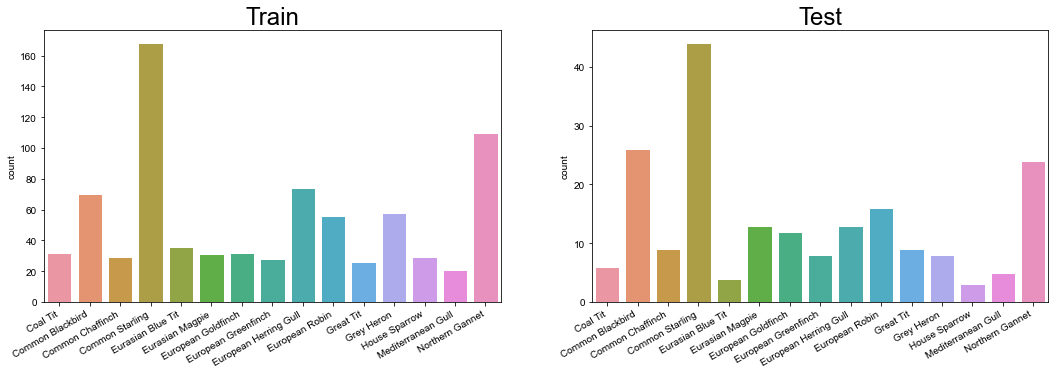

In [31]:
f, axes = plt.subplots(1, 2, figsize = (18,5))

l  = [categories[i] for i in train_labs_sort]
sns.set_style('darkgrid')
sns.countplot(x = l, ax = axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize = 15)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 30, horizontalalignment = 'right')
axes[0].set_title("Train", size = 24)

lt  = [categories[i] for i in test_labs_sort]
sns.set_style('darkgrid')
sns.countplot(x = lt, ax = axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize = 15)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 30, horizontalalignment = 'right')
axes[1].set_title("Test", size = 24)

In [32]:
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(categories)

Input shape: (5000, 129, 1)


In [33]:
#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

In [34]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    #layers.MaxPooling2D(),
    preprocessing.Resizing(128, 32), 
    #norm_layer,
    layers.RandomTranslation(
    height_factor = 0, width_factor = (-0.3, 0.3), fill_mode='wrap'),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 128, 32, 1)        0         
_________________________________________________________________
random_translation (RandomTr (None, 128, 32, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 30, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 13, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 6, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2880)              0

In [35]:
batch_size = 128
train_ds   = train_ds.batch(batch_size)
test_ds    = test_ds.batch(batch_size)
train_ds   = train_ds.cache().prefetch(AUTOTUNE)
test_ds    = test_ds.cache().prefetch(AUTOTUNE)

In [36]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [37]:
base_loss, base_acc = model.evaluate(test_ds)
print("Untrained model, accuracy: {:5.2f}%".format(100 * base_acc))

2/2 [==============================] - 63s 25s/step - loss: 2.8391 - accuracy: 0.0600
Untrained model, accuracy:  6.00%


In [38]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
7/7 [==============================] - 344s 52s/step - loss: 2.8027 - accuracy: 0.1412 - val_loss: 2.7189 - val_accuracy: 0.2000
Epoch 2/10
7/7 [==============================] - 1s 165ms/step - loss: 2.7212 - accuracy: 0.2175 - val_loss: 2.6684 - val_accuracy: 0.2300
Epoch 3/10
7/7 [==============================] - 1s 171ms/step - loss: 2.6946 - accuracy: 0.2175 - val_loss: 2.6358 - val_accuracy: 0.2250
Epoch 4/10
7/7 [==============================] - 1s 162ms/step - loss: 2.6649 - accuracy: 0.2338 - val_loss: 2.6187 - val_accuracy: 0.2300
Epoch 5/10
7/7 [==============================] - 1s 157ms/step - loss: 2.6132 - accuracy: 0.2450 - val_loss: 2.5978 - val_accuracy: 0.2400
Epoch 6/10
7/7 [==============================] - 1s 166ms/step - loss: 2.5868 - accuracy: 0.2463 - val_loss: 2.5799 - val_accuracy: 0.2450
Epoch 7/10
7/7 [==============================] - 1s 176ms/step - loss: 2.5690 - accuracy: 0.2500 - val_loss: 2.5627 - val_accuracy: 0.2700
Epoch 8/10
7/7 [====

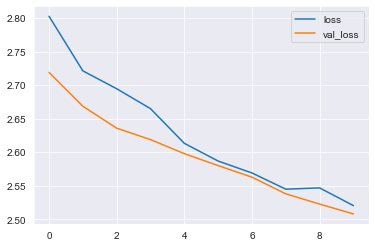

In [39]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

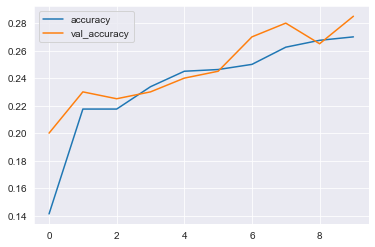

In [40]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [41]:
import plotly.graph_objs as go
metrics = history.history

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['loss'], 
                         mode = 'lines', name = 'Training',
                         line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_loss'], 
                         mode = 'lines', name = 'Validation',
                         line = dict(color='orange')))
fig.update_layout(title='Loss Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['accuracy'], 
                         mode = 'lines', name = 'Training',
                        line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_accuracy'], 
                         mode = 'lines', name = 'Validation',
                        line = dict(color='orange')))
fig.update_layout(title='Accuracy Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Accuracy')

fig.show()

In [44]:
from datetime import datetime

In [45]:
model.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+data_dir.replace('/','')+'_shallow_net.h5')

In [46]:
#todo: confusion matrix and other 
y_pred = np.argmax(model.predict(test_ds), axis=-1)
y_true = [y for _,y in test_ds.unbatch()]

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0

In [48]:
import plotly.figure_factory as ff

z = cm

x = categories
y = categories
y.reverse()

x.sort()
y.sort()

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                  yaxis=dict(autorange='reversed')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_pred_proba = model.predict(test_ds)[::,1]
#fpr, tpr, _  = roc_curve(y_true,  y_pred_proba)

In [50]:
pred_lists = model.predict(test_ds)

In [51]:
pred_df = pd.DataFrame(pred_lists, columns = categories)

In [52]:
pred_df_softmax = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)

In [53]:
#pred_df_softmax.to_numpy()

In [54]:
from sklearn.preprocessing import OneHotEncoder
onehot_data = OneHotEncoder(sparse=False)
onehot_data = onehot_data.fit_transform(np.array(y_true).reshape(len(y_true),1))

In [55]:
#onehot_data
from itertools import cycle

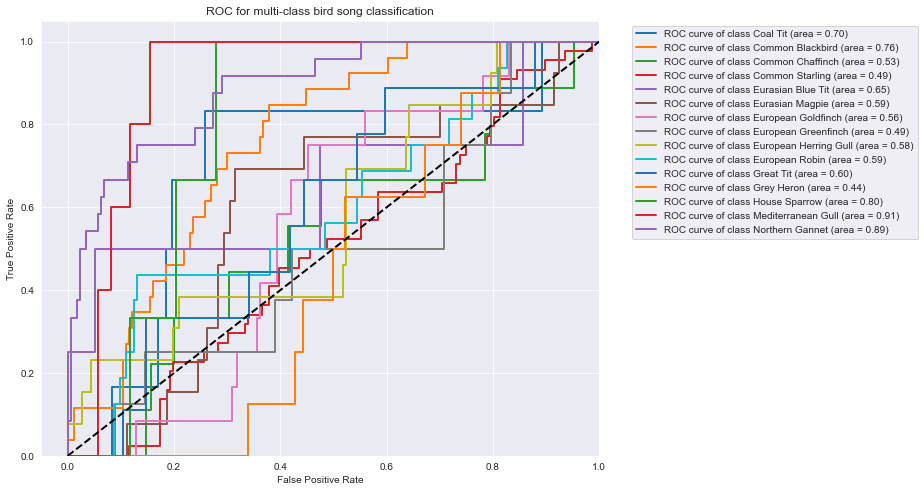

In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(categories)
lw = 2
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(onehot_data[:, i], pred_df_softmax.to_numpy()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             #color=color, 
             lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class bird song classification')
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1))#, loc='upper right')
plt.show()

In [57]:
for i in range(n_classes):
    print('AUC of {0}: \t{1:0.2f}'.format(categories[i], roc_auc[i]))

AUC of Coal Tit: 	0.70
AUC of Common Blackbird: 	0.76
AUC of Common Chaffinch: 	0.53
AUC of Common Starling: 	0.49
AUC of Eurasian Blue Tit: 	0.65
AUC of Eurasian Magpie: 	0.59
AUC of European Goldfinch: 	0.56
AUC of European Greenfinch: 	0.49
AUC of European Herring Gull: 	0.58
AUC of European Robin: 	0.59
AUC of Great Tit: 	0.60
AUC of Grey Heron: 	0.44
AUC of House Sparrow: 	0.80
AUC of Mediterranean Gull: 	0.91
AUC of Northern Gannet: 	0.89


In [58]:
fig = go.Figure()
#colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i in range(n_classes):
    fig.add_trace(go.Scatter(x = fpr[i], y = tpr[i], 
                             mode = 'lines', 
                             name = '{0} (area = {1:0.2f})'.format(categories[i], roc_auc[i])))
fig.update_layout(title       = 'ROC for multi-class bird song classification',
                  xaxis_title = 'False Positive Rate',
                  yaxis_title = 'True Positive Rate')

fig.show()